<a href="https://colab.research.google.com/github/yogeshdhome/Coursera-IBM-AI-ML-Course/blob/master/Fake_News_Detection_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
fake = pd.read_csv('/content/sample_data/Fake.csv')
real = pd.read_csv('/content/sample_data/True.csv')

In [4]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [5]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [6]:
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [7]:
fake.sample(5)

,title,text,subject,date
3904,Obama SHAMES The Hell Out Of Trump And His He...,President Obama has shown he s a human being w...,News,"November 7, 2016"
11349,BREAKING: TOMI LAHREN SUSPENDED From The Blaze...,Conservative media company The Blaze has suspe...,politics,"Mar 20, 2017"
18055,Kind Woman Brings Beer to Reporter During Hurr...,A kind woman brought Fox News reporter Casey S...,left-news,"Aug 26, 2017"
13685,EMBARRASSING: Pro-Gun Control Reporter Attempt...,What is it about liberal men that makes a woma...,politics,"Jun 15, 2016"
7847,Republican Lawmaker Says Rape Won’t Cause Pre...,A male Idaho Republican with five daughters ma...,News,"February 26, 2016"


In [8]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [9]:
real['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [35]:
len(fake['text'].max())

1150

In [34]:
len(real['text'].max())

3293

In [36]:
fake['class'] = 0
real['class'] = 1

In [37]:
fake = fake.drop(['title','subject','date'], axis=1)
real = real.drop(['title','subject','date'], axis=1)

In [38]:
fake.columns

Index(['text', 'class'], dtype='object')

In [39]:
dataset = fake.append(real, ignore_index=True)

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   class   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [41]:
dataset['class'].value_counts()

0    23481
1    21417
Name: class, dtype: int64

In [42]:
dataset['text'].head()

0    Donald Trump just couldn t wish all Americans ...
1    House Intelligence Committee Chairman Devin Nu...
2    On Friday, it was revealed that former Milwauk...
3    On Christmas day, Donald Trump announced that ...
4    Pope Francis used his annual Christmas Day mes...
Name: text, dtype: object

#Remove the special keywords from text column

In [44]:
import re
import nltk
from wordcloud import WordCloud

WordCloud Map

In [54]:
fake_text = ' '.join(list(fake['text']))
real_text = ' '.join(list(real['text']))

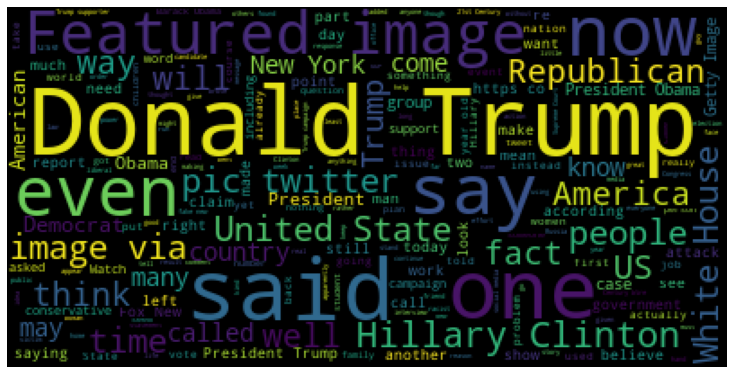

In [58]:
wordcloud = WordCloud()
plt.figure(figsize=(10,8))
plt.imshow(wordcloud.generate(fake_text))
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

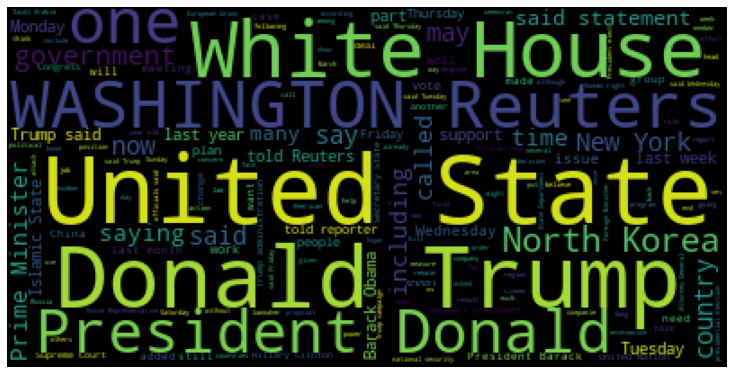

In [57]:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud.generate(real_text))
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [61]:
def remove_special_characters(sentence):
  return re.sub(r'\W+',' ',sentence)


In [62]:
dataset['text'] = dataset['text'].apply(lambda x: remove_special_characters(x))

In [66]:
dataset['text'].tail()

44893    BRUSSELS Reuters NATO allies on Tuesday welcom...
44894    LONDON Reuters LexisNexis a provider of legal ...
44895    MINSK Reuters In the shadow of disused Soviet ...
44896    MOSCOW Reuters Vatican Secretary of State Card...
44897    JAKARTA Reuters Indonesia will buy 11 Sukhoi f...
Name: text, dtype: object

# Lets not remove news source information for now

In [71]:
import nltk.corpus


44898